config

In [12]:
import psycopg2
import random
import json
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import SparsePCA,PCA
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,precision_score,recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix


from sklearn import tree

In [13]:
def getdata(query):
    with open('config.json', 'r') as f:
        config_dict = json.load(f)
    #print(config_dict)
    #print(config_dict['password'])
    record = 0
    #string = "user=config_dict['user'] password = config_dict['password'] host = config_dict['host'] dbname = config_dict['dbname'] port = config_dict['port']"
    try:
        connection = psycopg2.connect(user=config_dict['user'],
                                      password=config_dict['password'],
                                      host=config_dict['host'],
                                      dbname=config_dict['dbname'],
                                      port=config_dict['port'])
        cursor = connection.cursor()
        # Print PostgreSQL Connection properties
        print ( connection.get_dsn_parameters(),"\n")
        # Print PostgreSQL version
        #cursor.execute("SELECT version();")
        cursor.execute(query)
        record = cursor.fetchall()
        #print("You are connected to - ", record,"\n")
    except (Exception, psycopg2.Error) as error :
        print ("Error while connecting to PostgreSQL", error)
    finally:
        #closing database connection.
            if(connection):
                cursor.close()
                connection.close()
                print("PostgreSQL connection is closed")
    return record;

t-sne and decision tree

In [17]:
# SVM section

#total_engaged_time, days_since_user_signup
query = '''SELECT
    total_engaged_time, months_since_user_signup, total_overview_views,
         total_search_views,total_export_actions,total_report_actions,
         total_detail_views,total_overlay_views,total_info_views,
         total_referrer_views,
         total_author_views,total_section_views,total_tag_views,total_page_type_views,total_settings_views,
         total_campaign_group_actions,total_campaign_views,total_share_page_actions,
         total_token_actions,
         did_return_visit 
   FROM visitors_by_month;'''

query = '''(SELECT TOP 20000
    total_engaged_time, months_since_user_signup, total_overview_views,
         total_search_views,total_export_actions,total_report_actions,
         total_detail_views,total_overlay_views,total_info_views,
         total_referrer_views,
         total_author_views,total_section_views,total_tag_views,total_page_type_views,total_settings_views,
         total_campaign_group_actions,total_campaign_views,total_share_page_actions,
         total_token_actions,
         did_return_visit 
   FROM visitors_by_month
   where did_return_visit = 0 
   )
UNION ALL
(SELECT TOP 20000
    total_engaged_time, months_since_user_signup, total_overview_views,
         total_search_views,total_export_actions,total_report_actions,
         total_detail_views,total_overlay_views,total_info_views,
         total_referrer_views,
         total_author_views,total_section_views,total_tag_views,total_page_type_views,total_settings_views,
         total_campaign_group_actions,total_campaign_views,total_share_page_actions,
         total_token_actions,
         did_return_visit 
   FROM visitors_by_month
   where did_return_visit = 1 
   );'''


data = getdata(query)
data = [[data if data is not None else 0 for data in x_i] for x_i in data]
data = [(x_i[0:len(x_i)-1],x_i[-1]) for x_i in data]

X = [x_i[0] for x_i in data]
y = [x_i[1] for x_i in data]

# train,valid, test split
# train = data[0:9999]
# valid = data[10000:10999]
# test = data[11000:11999]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

print(len(X_train),len(X_valid),len(X_test))


# # subsample from training to fix inbalance
# red = np.array([x_i for x_i in train if x_i[-1] ==1])
# blue = np.array([x_i for x_i in train if x_i[-1] ==0])
# num = min(len(red),len(blue))

# newred = red[0:num]
# newblue = blue[0:num]

# print("hihi",len(newred),len(newblue))
# train = np.concatenate((newred,newblue))
# print("hi",train[0])

# split 

# X_train = [x_i[0] for x_i in train]
# y_train = [x_i[1] for x_i in train]
# X_valid = [x_i[0] for x_i in valid]
# y_valid = [x_i[1] for x_i in valid]

# print('xtrain',X_train[0:5])
# don't touch the test set until final report!!!!!!!!
#X_test = [i[0] for i in test]
#y_test = [i[1] for i in test]



# # train pca
X_train = StandardScaler().fit_transform(X_train)
X_valid = StandardScaler().fit_transform(X_valid)
#pca = SparsePCA(n_components=6)
pca = PCA(2)
pca.fit(X_train) 

print(pca.n_components_ )




{'user': 'mlcalss', 'dbname': 'nydn', 'host': 'dbt-dpl-dev.c913t1mfbggj.us-east-1.redshift.amazonaws.com', 'port': '5439', 'tty': '', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 

PostgreSQL connection is closed
32400 3600 4000
2


In [18]:
from sklearn.neighbors import KNeighborsClassifier
#embed data
newX_train = pca.transform(X_train)
newX_valid = pca.transform(X_valid)

knn = KNeighborsClassifier()
knn.fit(newX_train,y_train)
y_pred = knn.predict(newX_valid)
print('confusion matrix', confusion_matrix(y_valid,y_pred))
print('accuracy',accuracy_score(y_pred,y_valid))
print('precision',precision_score(y_valid,y_pred))
print('recall',recall_score(y_valid,y_pred))

confusion matrix [[ 162 1650]
 [ 194 1594]]
accuracy 0.48777777777777775
precision 0.4913686806411837
recall 0.8914988814317674


[-0.20105652 -0.20615998]
1 1


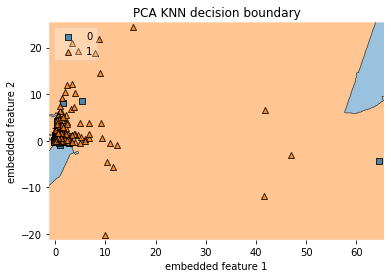

In [19]:
i = 2
print(newX_valid[i])
print(y_pred[i],y_valid[i])

from mlxtend.plotting import plot_decision_regions
value = 0
width = 100000000000.75
plot_decision_regions(newX_valid, np.array(y_valid), clf=knn, 
                      filler_feature_values={2: value},
                      filler_feature_ranges={2: width},
                      legend=2)
plt.title('PCA KNN decision boundary')
plt.xlabel('embedded feature 1')
plt.ylabel('embedded feature 2')
plt.show()